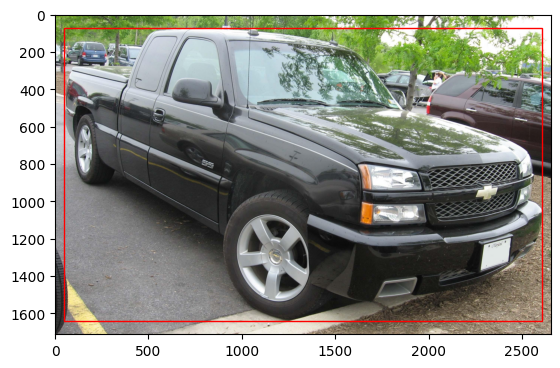

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import tensorflow.keras.backend as K
path_annotrain = "../../datasets_train/train_annotation/_annotation.csv"

train_annotation = pd.read_csv(path_annotrain, index_col=0)

bbox_train_full = train_annotation.loc[
    :, ["im_name", "x_min", "y_min", "x_max", "y_max"]
]

im_test = bbox_train_full.iloc[124, 0]
x1, y1, x2, y2 = bbox_train_full.loc[bbox_train_full["im_name"] == im_test].iloc[0, 1:]


def load_plot(im_name, x1, y1, x2, y2):

    im = np.asanyarray(Image.open(f"../../datasets_train/train/{im_name}"))

    # Display the image
    plt.imshow(im)

    # Get the current reference
    ax = plt.gca()

    # Create a Rectangle patch
    rect = patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor="r", facecolor="none"
    )

    # Add the patch to the Axes
    ax.add_patch(rect)
    plt.show()


load_plot(im_test, x1, y1, x2, y2)

In [2]:
bbox_train_full = bbox_train_full.dropna(how = 'any')
bbox_train_full
bbox_train_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2089 entries, 985 to 106
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   im_name  2089 non-null   object 
 1   x_min    2089 non-null   float64
 2   y_min    2089 non-null   float64
 3   x_max    2089 non-null   float64
 4   y_max    2089 non-null   float64
dtypes: float64(4), object(1)
memory usage: 97.9+ KB


In [3]:
from sklearn.model_selection import train_test_split

bbox_train, bbox_eval = train_test_split(
    bbox_train_full, test_size=0.2, random_state=1234
)

print(bbox_train.shape)
print(bbox_eval.shape)

(1671, 5)
(418, 5)


In [4]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

class DataPreprocessor:
    # Write your code to preprocess the data

    #-----------------------------Sample Code ( to be deleted ) -------------------------------
    def __init__(self, target_size=(256, 256)):
        self.target_size = target_size
    
    def preprocess_data(self, bbox_data, image_path):
        X = []  # List to store the preprocessed images
        y = []  # List to store the target labels (IOU-based bounding boxes)

        for idx, row in bbox_data.iterrows():
            im_name, x1, y1, x2, y2 = row
            im = load_img(f"{image_path}/{im_name}", target_size=self.target_size)
            im = img_to_array(im) / 255.0  # Normalize the image pixels to [0, 1]
            X.append(im)

            # Calculate scaling factors for bounding box coordinates
            orig_width, orig_height = load_img(f"{image_path}/{im_name}").size
            scale_x = self.target_size[0] / orig_width
            scale_y = self.target_size[1] / orig_height

            # Resize and scale bounding box coordinates
            x1_scaled = x1 * scale_x
            y1_scaled = y1 * scale_y
            x2_scaled = x2 * scale_x
            y2_scaled = y2 * scale_y

            target_label = [x1_scaled, y1_scaled, x2_scaled, y2_scaled]
            y.append(target_label)

        return np.array(X), np.array(y)

# Load and preprocess the data using the class
image_path = "../../datasets_train/train"
preprocessor = DataPreprocessor(target_size=(256, 256))
X_train, y_train = preprocessor.preprocess_data(bbox_train, image_path)
X_eval, y_eval = preprocessor.preprocess_data(bbox_eval, image_path)

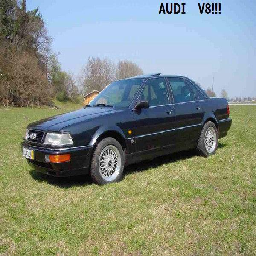

In [6]:
from PIL import Image
im = Image.fromarray((X_train[0] *255).astype(np.uint8))
im

In [7]:
import os
from PIL import Image
import numpy as np

def save_images(images, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for i, image_array in enumerate(images):
        image = Image.fromarray((image_array * 255).astype(np.uint8))
        image_path = os.path.join(output_dir, f'image_{i:04d}.jpg')
        image.save(image_path)

save_images(X_train, './dataset/train/images/')
save_images(X_eval, './dataset/val/images')

Devide train/eval data / get yolo_format label

In [8]:
def convert_to_yolo_format(bbox, image_width, image_height):
    x_min, y_min, x_max, y_max = bbox
    x_center = (x_min + x_max) / 2 / image_width
    y_center = (y_min + y_max) / 2 / image_height
    width = (x_max - x_min) / image_width
    height = (y_max - y_min) / image_height
    return x_center, y_center, width, height

def save_annotations(annotations, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for i, bbox in enumerate(annotations):
        annotation_path = os.path.join(output_dir, f'image_{i:04d}.txt')
        with open(annotation_path, 'w') as f:
            yolo_bbox = convert_to_yolo_format(bbox, 255, 255)
            class_id = 0  # Adjust the class ID as needed
            f.write(f"{class_id} {yolo_bbox[0]} {yolo_bbox[1]} {yolo_bbox[2]} {yolo_bbox[3]}\n")

save_annotations(y_train, './dataset/train/labels/')
save_annotations(y_eval, './dataset/val/labels')

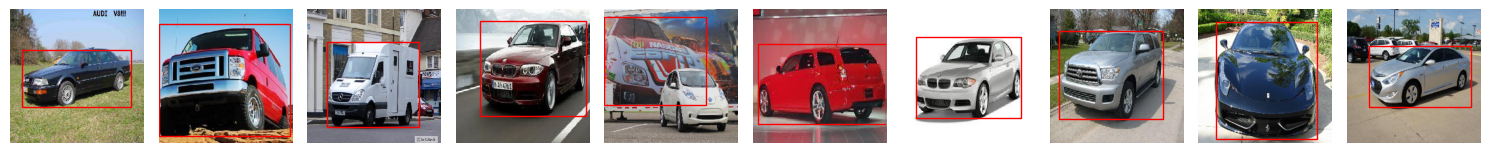

In [9]:
images = X_train[:10]  # Displaying the first 10 images
bbox_coords_list = y_train[:10]  # Bounding box coordinates for the first 10 images

# Set the figure size
plt.figure(figsize=(15, 5))  # Adjust the width and height as needed

# Plot images with bounding boxes
for i, (image, bbox_coords) in enumerate(zip(images, bbox_coords_list)):
    plt.subplot(1, len(images), i + 1)
    plt.imshow(image)
    ax = plt.gca()
    rect = plt.Rectangle((bbox_coords[0], bbox_coords[1]), bbox_coords[2] - bbox_coords[0], bbox_coords[3] - bbox_coords[1], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [10]:
import tensorflow as tf

def iou(y_true, y_pred):
    # Write your code for IOU function

    #-----------------------------Sample Code ( to be deleted ) -------------------------------
    # Compute the intersection coordinates
    xi1 = tf.maximum(y_true[:, 0], y_pred[:, 0])
    yi1 = tf.maximum(y_true[:, 1], y_pred[:, 1])
    xi2 = tf.minimum(y_true[:, 2], y_pred[:, 2])
    yi2 = tf.minimum(y_true[:, 3], y_pred[:, 3])

    # Calculate the area of intersection
    intersection_area = tf.maximum(xi2 - xi1, 0) * tf.maximum(yi2 - yi1, 0)

    # Calculate the areas of both bounding boxes
    true_area = (y_true[:, 2] - y_true[:, 0]) * (y_true[:, 3] - y_true[:, 1])
    pred_area = (y_pred[:, 2] - y_pred[:, 0]) * (y_pred[:, 3] - y_pred[:, 1])

    # Calculate the union area
    union_area = true_area + pred_area - intersection_area

    # Avoid division by zero
    epsilon = 1e-6
    iou = intersection_area / (union_area + epsilon)

    return iou


In [11]:
%cd yolov5
!python train.py --img 256 --batch 16 --epochs 10 --data dataset.yaml --weights yolov5s.pt --cache

c:\Users\juncye\OneDrive - Capgemini\Desktop\data_challenge_mines-main\Welcoming notebook\Solution_JY\yolov5


WARNING  'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING  'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")

train: weights=yolov5s.pt, cfg=, data=dataset.yaml, hyp=data\hyps\hyp.scratch-low.yaml, epochs=10, batch_size=16, imgsz=256, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs\train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], sa

In [16]:

%load_ext tensorboard
%tensorboard --logdir runs


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


'kill' is not recognized as an internal or external command,
operable program or batch file.


Reusing TensorBoard on port 6006 (pid 10004), started 17:56:16 ago. (Use '!kill 10004' to kill it.)

In [13]:
%cd yolov5
!python detect.py --weights runs/train/exp7/weights/best.pt --source runs/train/exp7/image_0000.jpg


[WinError 2] The system cannot find the file specified: 'yolov5'
c:\Users\juncye\OneDrive - Capgemini\Desktop\data_challenge_mines-main\Welcoming notebook\Solution_JY\yolov5


WARNING  'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING  'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")

detect: weights=['runs/train/exp7/weights/best.pt'], source=runs/train/exp7/image_0000.jpg, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs\detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, v